# Kickstarter analysis

- Explore other modelling techniques (NNs)
- Fix lime interpretation

## Libraries & functions

In [0]:
from fastai import *
from fastai.text import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#path = "/content/gdrive/My Drive/Personal_projects/Kickstarter/"

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Personal_projects/Kickstarter/'
dest= Path(base_dir + "models/")

try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

Mounted at /content/gdrive
File Already Exists


In [3]:
#!pip install langdetect
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn
import autosklearn.classification

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   194  100   194    0     0   1060      0 --:--:-- --:--:-- --:--:--  1060


In [4]:
!pip install lime
!pip install lime.lime_tabular
!pip install shap
!pip install pdpbox

ERROR: Could not find a version that satisfies the requirement lime.lime_tabular (from versions: none)
ERROR: No matching distribution found for lime.lime_tabular


In [0]:
# Import useful libraries and change settings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats
import re
#import graphviz
import math
import IPython
import sys
import matplotlib.pyplot as plt
import pdb
from random import random
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import re
import seaborn as sns


# General ML functions
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn import metrics
import sklearn.model_selection as ms
from sklearn.metrics import confusion_matrix
import autosklearn.classification
#from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

# Model understandability
import lime
import lime.lime_tabular
import shap
from pdpbox import pdp, get_dataset, info_plots

#from textblob import TextBlob

# General settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [0]:
# Use functions lifted from legacy implementation of FastAI

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

# For model interpretation

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def se(x,y): return (x-y)**2

def mse(x,y): return ((x-y)**2).mean()

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# For visualisation

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
    
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def detect_language(text):
    try:
        return detect(text)
    except:
        return "Language Not Detected"


def print_outputs(df1,df2,y1,y2):
  a = "Train results, "
  b = "Test results, "
  print(a,"f1_score: ",metrics.f1_score(df1, y1))
  print(b,"f1_score: ",metrics.f1_score(df2, y2))
  print("-------")
  print(a,"ROC_score: ",metrics.roc_auc_score(df1, y1))
  print(b,"ROC_score: ",metrics.roc_auc_score(df2, y2))
  print("-------")
  print(a,"accuracy_score: ", metrics.accuracy_score(df1, y1))
  print(b,"accuracy_score: ",metrics.accuracy_score(df2, y2))


def train_val_test(data):

  a = train_df_text.shape[0]
  b = valid_df_text.shape[0]
  c = test_df_text.shape[0]

  cut1 = data[0:a]
  cut2 = data[a:a+b]
  cut3 = data[a+b:a+b+c]
  return cut1, cut2, cut3

## Data engineering

In [0]:
# Read and cleanse data
df = pd.read_csv(base_dir + 'kickstarter_model.csv')
df['randNumCol'] = np.random.randint(0,1000, size=len(df))
df.drop(['pledged', 'staff_pick','blurb_len','goal'],axis=1, inplace=True)

In [8]:
creator_count = df[df.launched_by_year<2018][['creator_id','main_category']].groupby(['creator_id']).count()
creator_count.reset_index(inplace=True)
creator_count.columns = ['creator_id','count_projects_per_creator']
df.merge(creator_count, how='left', on='creator_id')
df.fillna(0, inplace=True)
print(df.shape)
df.columns

(175200, 28)


Index(['country', 'town', 'county', 'main_category', 'subcategory',
       'funding_window', 'creation_window', 'total_window', 'launched_by_year',
       'launched_by_month', 'launched_by_day', 'currency', 'static_usd_rate',
       'usd_type', 'blurb', 'slug', 'polarity', 'subjectivity', 'creator_type',
       'creator_id', 'disable_communication', 'is_starrable', 'usd_pledged',
       'goal_usd', 'funding_rate', 'successful', 'perc_target', 'randNumCol'],
      dtype='object')

In [9]:
# Add new log variables for widely distributed variables

df['goal_usd_log'] = np.log(df.goal_usd)
df['funding_rate_log'] = np.log(df.funding_rate)
df.drop(['goal_usd'], axis=1, inplace=True)
df.drop(['funding_rate'], axis=1, inplace=True)
df.head()

,country,town,county,main_category,subcategory,funding_window,creation_window,total_window,launched_by_year,launched_by_month,launched_by_day,currency,static_usd_rate,usd_type,blurb,slug,polarity,subjectivity,creator_type,creator_id,disable_communication,is_starrable,usd_pledged,successful,perc_target,randNumCol,goal_usd_log,funding_rate_log
0,US,Minneapolis,MN,comics,Graphic Novels,30.0,10.0,40.0,2015,8,15,USD,1.000000,international,"The true biography of the historical figure, w...",strange-wit-an-original-graphic-novel-about-ja...,0.033333,0.383333,Individual,1695121020,False,False,14740.630000,True,1.228386,539,9.392662,5.991465
1,GB,London,England,technology,Apps,60.0,12.0,72.0,2018,6,20,GBP,1.327131,domestic,FAM is the new mobile app which combines event...,fam-find-a-motive-mobile-app,0.084848,0.260606,Organisation,67455724,False,False,14.598443,False,0.000146,598,11.785857,7.691512
2,US,New York,NY,comics,Graphic Novels,30.0,28.0,58.0,2016,10,4,USD,1.000000,international,A graphic novel about two magical ladies in love.,destiny-ny-a-graphic-novel,0.333333,0.666667,Individual,248241887,False,False,21799.000000,True,1.089950,648,9.903488,6.502290
3,US,Logan,UT,publishing,Periodicals,30.0,52.0,82.0,2011,9,5,USD,1.000000,domestic,We are publishing a magazine that focuses on t...,publishing-magus-magazine,0.000000,0.000000,Individual,1345074053,False,False,10.000000,False,0.002000,433,8.517193,5.115996
4,AU,Sydney,NSW,film & video,Drama,30.0,20.0,50.0,2016,8,23,AUD,0.762515,domestic,"A dark and magical film set in a brothel, an u...",the-fishbowl-1,0.243750,0.562500,Individual,1819445241,False,False,8249.563420,False,0.086838,388,11.078546,7.677348


In [0]:
df = df[df.main_category	 == 'technology']
df_fail = df[df.successful == False].sample(df[df.successful == True].shape[0], random_state=1)
df_success = df[df.successful == True]
df = pd.concat([df_success, df_fail], axis=0)

In [11]:
# Filter for technology and split by train, validation & test
#df = df[df.main_category	 == 'technology']
#print("Technology: ",df.shape)
df.sort_values(by = 'launched_by_year', ascending=True, inplace=True)
df.reset_index(drop = True, inplace=True)
train_df_text = df[df.launched_by_year < 2018]
valid_df_text = df[df.launched_by_year == 2018]
test_df_text = df[df.launched_by_year == 2019]
print(train_df_text.shape)
print(valid_df_text.shape)
print(test_df_text.shape)

(9854, 28)
(2183, 28)
(1689, 28)


In [12]:
data_lm = TextLMDataBunch.from_df('.',train_df=train_df_text, valid_df=valid_df_text, text_cols='blurb')

In [13]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.4)
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(7976, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(7976, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=7976, bias=True)
    (output_dp): RNNDropout()
  )
)

## Modelling (no need to re-run)

In [0]:
#learn_lm.lr_find()
#learn_lm.recorder.plot(skip_end=15)

In [15]:
learn_lm.freeze()
learn_lm.fit_one_cycle(2, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.021587,4.675062,0.251271,05:26
1,4.426922,4.454560,0.267943,05:25


In [0]:
learn_lm.save(dest/'stage-1-model')

In [17]:
learn_lm.load(dest/'stage-1-model')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9854 items)
x: LMTextList
xxbos i make cool icons for iphone developers at http : / / xxunk and if i can collect $ 500 in donations , i 'll release the whole set ...,xxbos xxmaj this is a project to create a free iphone app for browsing xxmaj wikipedia offline . xxmaj the code will be open source and i 'll launch it with ...,xxbos xxunk is a curated video space with a focus on non - fiction storytelling and art from around the world . xxmaj we help filmmakers to promote their work .,xxbos xxmaj need sleep ? xxmaj we can help . xxmaj information , support and research to help families . xxmaj we 'll keep it simple , because we know you 're tired .,xxbos xxmaj you may be thinking : " a fusion reactor ? xxmaj that ’s not very exciting , i see fusion every day . " xxmaj but . xxmaj how often do you see fusion inside of a xxmaj xxunk ...
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2183 items)
x: LMTextList
xxbos xxmaj the ergonomi

In [0]:
learn_lm.unfreeze()
#learn_lm.lr_find()
#learn_lm.recorder.plot(skip_end=15)

In [19]:
learn_lm.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.709860,4.324544,0.281387,08:00
1,3.481812,4.343384,0.283019,08:01


In [0]:
learn_lm.save(dest/'stage-2-model')
learn_lm.save_encoder(dest/'fine_tuned_enc')

## NLP generation

In [0]:
learn_lm.load(dest/'stage-2-model');

In [22]:
TEXT = "The product"
N_WORDS = 50
N_SENTENCES = 10
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

The product is a expansion module with many features that let you build a wireless speaker using Wi - Fi , Wi - Fi , Wi - Fi , AUX Headset xxbos The most effective and effective way to keep your child safe

The product that brings you a peace of mind , car seat , and brands . It is the First Uber Tesla Trike . xxbos This project will take a Swiss and Professional Product Buyer Gloves to Whole Family

The product that is perfect for swimming , swimming , and play . It makes life easier for your family . xxbos Growing pets : Finally , an adjustable LED portability that can change you with the NFC key fob with a colorful scanner . xxbos 3rd

The product that doubles as a Arduino Uno compatible with a Scientifically proven and hackable Arduino processor . xxbos The this battery is a great solution that ready to fly with two almost no heat outputs xxbos Greedy and sick of e - learning now ,

The product that enables you to send multiple devices to the Web . Get them covered . Make it big ! 

## NLP understanding

### Classification - which projects succeed?

In [0]:
df_rf_1 = df.drop(['perc_target','usd_pledged'],axis=1)
train_cats(df_rf_1)
df_class, y_class, nas_class = proc_df(df_rf_1, 'successful', max_n_cat=20) #16 subcategories
train_df, valid_df, test_df = train_val_test(df_class)
train_y, valid_y, test_y = train_val_test(y_class)

### Baseline model

In [24]:
# Test outcome predicting majority class (failure) for all projects

df['baseline_pred'] = df['subcategory'].apply(lambda x: 1 if x in ['Technology','Gadgets','Hardware'] else 0) 
baseline_pred = df.baseline_pred.to_numpy()
train_base_pred, valid_base_pred, test_base_pred = train_val_test(baseline_pred)
print_outputs(train_base_pred, valid_base_pred, train_y, valid_y)
df.drop(['baseline_pred'], axis=1, inplace=True)

Train results,  f1_score:  0.530478589420655
Test results,  f1_score:  0.5728395061728395
-------
Train results,  ROC_score:  0.6629160793502603
Test results,  ROC_score:  0.6742711648024998
-------
Train results,  accuracy_score:  0.621676476557743
Test results,  accuracy_score:  0.6830050389372423


### 1) Project data only

In [25]:
rf = RandomForestClassifier(n_estimators= 10, n_jobs=3, class_weight = 'balanced')
grid_param_rf = [{'min_samples_leaf': [2,5,10,20,30], 'max_features' :  ['sqrt',0.2,0.5,1]}]
para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, cv=5, scoring = 'roc_auc', return_train_score=True)
%time para_search_rf = para_search_rf.fit(train_df, train_y)
tuning_results_rf = pd.DataFrame(para_search_rf.cv_results_)
tuning_results_rf.sort_values('mean_test_score', ascending=False).head()

CPU times: user 11.6 s, sys: 941 ms, total: 12.6 s
Wall time: 39.1 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.095693,0.002037,0.110291,0.000220,sqrt,30,"{'max_features': 'sqrt', 'min_samples_leaf': 30}",0.787631,0.789357,0.753401,0.751705,0.723658,0.761154,0.024704,1,0.878158,0.877492,0.872556,0.890207,0.892779,0.882239,0.007843
16,0.075698,0.002263,0.110315,0.000179,1,5,"{'max_features': 1, 'min_samples_leaf': 5}",0.740575,0.801540,0.759294,0.747832,0.720343,0.753920,0.026977,2,0.890674,0.882110,0.901836,0.895436,0.917936,0.897598,0.012034
2,0.112371,0.003045,0.110961,0.000746,sqrt,10,"{'max_features': 'sqrt', 'min_samples_leaf': 10}",0.764115,0.775566,0.727919,0.774560,0.682960,0.745030,0.035533,3,0.923903,0.928938,0.933347,0.935355,0.939602,0.932229,0.005395
15,0.083708,0.002110,0.110218,0.000126,1,2,"{'max_features': 1, 'min_samples_leaf': 2}",0.775576,0.787870,0.734876,0.731890,0.689649,0.743978,0.034942,4,0.968293,0.971963,0.974010,0.974977,0.978322,0.973513,0.003322
17,0.069727,0.001781,0.110253,0.000225,1,10,"{'max_features': 1, 'min_samples_leaf': 10}",0.758466,0.793831,0.744957,0.703415,0.698503,0.739839,0.035562,5,0.830764,0.840413,0.856918,0.840932,0.875829,0.848971,0.015836


In [26]:
best_rf_1 = RandomForestClassifier(n_estimators = 5000)
best_rf_1 = para_search_rf.best_estimator_
best_rf_1.fit(train_df, train_y)
print(confusion_matrix(y_class,best_rf_1.predict(df_class)))
rf_feat_importance(best_rf_1, df_class).head(10)

[[5086 1777]
 [1569 5294]]


,cols,imp
6,launched_by_year,0.194443
18,goal_usd_log,0.097465
4,creation_window,0.096684
59,creator_type_Organisation,0.083820
19,funding_rate_log,0.080640
37,subcategory_Web,0.058074
29,subcategory_Hardware,0.051413
56,usd_type_international,0.045322
28,subcategory_Gadgets,0.030766
3,funding_window,0.027134


In [27]:
predict_train = best_rf_1.predict(train_df)
predict_valid = best_rf_1.predict(valid_df)
predict_test = best_rf_1.predict(test_df)
print_outputs(predict_train, predict_valid, train_y, valid_y)

Train results,  f1_score:  0.7889584964761158
Test results,  f1_score:  0.655672163918041
-------
Train results,  ROC_score:  0.7807789934888483
Test results,  ROC_score:  0.684734654409444
-------
Train results,  accuracy_score:  0.7812056017860767
Test results,  accuracy_score:  0.6843792945487861


### 2) Text data only 

In [28]:
data_clas = TextClasDataBunch.from_df('.',train_df=train_df_text, valid_df=valid_df_text, text_cols = 'blurb', label_cols = 'successful',bs=16)
data_clas.show_batch()

text,target
"xxbos xxmaj cult of the xxmaj month ! \n xxmaj where xxmaj you xxmaj belong ! \n xxmaj on the xxunk of xxmaj every xxmaj month a xxmaj new xxmaj cult ! \n xxmaj do n't xxmaj fight xxmaj the xxmaj illuminati , xxmaj be xxmaj the xxmaj illuminati ! \n xxmaj cult xxmaj app",True
"xxbos xxmaj all - in - xxmaj one water bottle with xxmaj filtration , xxup uv xxmaj light xxmaj purifier , xxmaj bluetooth xxmaj speaker , xxmaj cup xxmaj lid , xxmaj infuser , xxmaj strobe xxmaj light , xxmaj lantern , xxmaj heating & more !",True
"xxbos xxup extra xxup features : xxmaj battery - xxmaj free xxmaj heated xxmaj gloves , xxmaj comfort xxmaj zone xxup xxunk to xxup xxunk , xxmaj water xxmaj resistant , xxunk xxmaj warranty , xxmaj packable , xxmaj ultra xxmaj thin , xxmaj washable",True
"xxbos * xxup final xxup week * - xxmaj starting from $ xxunk xxmaj world 's xxmaj thinnest ( xxunk mm ) , xxmaj most xxmaj beautiful and xxmaj practical xxmaj webcam xxmaj security . xxmaj cover your xxmaj webcam in xxmaj style !",True
xxbos xxmaj konekt xxmaj dash is a cellular dev kit ( xxmaj arduino / xxmaj pi / + ) powered by xxmaj konekt 's global data plan ( 100 + countries ) & xxmaj cloud ( xxunk / sub / store / route ),True


In [0]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3) #.to_fp16()
#learn_c.load_encoder(dest/'fine_tuned_enc')
learn_c.freeze()
#learn_c.lr_find()
#learn_c.recorder.plot()

In [30]:
learn_c.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.702513,0.731317,0.414567,03:42
1,0.693421,0.729349,0.414567,03:53


In [66]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.566232,0.662361,0.628951,14:28
1,0.475518,0.689253,0.642235,14:15


In [0]:
learn_c.save(dest/'classification-model');

In [33]:
learn_c.load(dest/'classification-model')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9854 items)
x: TextList
xxbos i make cool icons for iphone developers at http : / / xxunk and if i can collect $ 500 in donations , i 'll release the whole set ...,xxbos xxmaj this is a project to create a free iphone app for browsing xxmaj wikipedia offline . xxmaj the code will be open source and i 'll launch it with ...,xxbos xxunk is a curated video space with a focus on non - fiction storytelling and art from around the world . xxmaj we help filmmakers to promote their work .,xxbos xxmaj need sleep ? xxmaj we can help . xxmaj information , support and research to help families . xxmaj we 'll keep it simple , because we know you 're tired .,xxbos xxmaj you may be thinking : " a fusion reactor ? xxmaj that ’s not very exciting , i see fusion every day . " xxmaj but . xxmaj how often do you see fusion inside of a xxmaj xxunk ...
y: CategoryList
True,True,True,True,True
Path: .;

Valid: LabelList (2183 items)
x: TextList
xxbos xxma

In [34]:
%time df["prediction_from_lang_model"] = df.blurb.apply(lambda x: learn_c.predict(x))
df['prob_success_lang_model'] = df.prediction_from_lang_model.apply(lambda x: float(str(x[2][1])[7:13]))
df['lang_model_flag'] = df.apply(lambda x: True if x['prob_success_lang_model'] > 0.5 else False, axis=1)
#df.head(5)

CPU times: user 37min 33s, sys: 9.36 s, total: 37min 43s
Wall time: 23min 20s


In [0]:
#metrics.confusion_matrix(df.successful, df.lang_model_flag, labels=None, sample_weight=None, normalize=None)

In [0]:
df.to_csv(dest/"full_dataset.csv", index=False)

In [0]:
df = pd.read_csv(dest/"full_dataset.csv")

In [38]:
predict_train, predict_valid, predict_test = train_val_test(df.lang_model_flag)
print_outputs(predict_train, predict_valid, train_y, valid_y)

Train results,  f1_score:  0.8025305015815636
Test results,  f1_score:  0.6424870466321243
-------
Train results,  ROC_score:  0.7847902629825791
Test results,  ROC_score:  0.6644231178267269
-------
Train results,  accuracy_score:  0.7782626344631621
Test results,  accuracy_score:  0.652313330279432


### Combined text and project data

In [0]:
df_rf = df.drop(['perc_target','usd_pledged','prediction_from_lang_model','lang_model_flag'],axis=1)
train_cats(df_rf)
df_class, y_class, nas_class = proc_df(df_rf, 'successful', max_n_cat=20)
train_df_comb, valid_df_comb, test_df_comb = train_val_test(df_class)
train_y_comb, valid_y_comb, test_y_comb = train_val_test(y_class)

In [40]:
print(train_df.shape)
valid_df_comb.head()

(9854, 61)


,country,town,county,funding_window,creation_window,total_window,launched_by_year,launched_by_month,launched_by_day,static_usd_rate,blurb,slug,polarity,subjectivity,creator_id,disable_communication,is_starrable,randNumCol,goal_usd_log,funding_rate_log,prob_success_lang_model,main_category_technology,main_category_nan,subcategory_3D Printing,subcategory_Apps,subcategory_Camera Equipment,subcategory_DIY Electronics,subcategory_Fabrication Tools,subcategory_Flight,subcategory_Gadgets,subcategory_Hardware,subcategory_Makerspaces,subcategory_Robots,subcategory_Software,subcategory_Sound,subcategory_Space Exploration,subcategory_Technology,subcategory_Wearables,subcategory_Web,subcategory_nan,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,currency_nan,usd_type_0,usd_type_domestic,usd_type_international,usd_type_nan,creator_type_Individual,creator_type_Organisation,creator_type_nan
9854,22,663,342,60.0,1.0,61.0,2018,12,6,1.000000,10747,11168,0.000000,0.000000,275443641,False,False,472,8.853665,4.759321,0.7178,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
9855,8,1395,211,60.0,11.0,71.0,2018,9,10,1.156203,7717,7815,0.068182,0.560606,2058447216,False,False,787,10.230066,6.135721,0.4532,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
9856,22,2089,7,20.0,73.0,93.0,2018,3,3,1.000000,3325,13190,-0.035714,0.107143,201075383,False,False,363,8.517193,5.521461,0.5492,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
9857,4,2347,268,30.0,0.0,30.0,2018,7,15,0.759725,8026,13043,0.136364,0.454545,292344942,False,False,219,10.721858,7.320660,0.4641,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
9858,22,1982,204,35.0,3.0,38.0,2018,7,3,1.000000,3878,7007,0.178125,0.425000,970754453,False,False,865,6.907755,3.352407,0.8076,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [41]:
rf = RandomForestClassifier(n_estimators= 20, n_jobs=3, class_weight = 'balanced')
grid_param_rf = [{'min_samples_leaf': [2,5,10,20,30], 'max_features' :  ['sqrt',0.2,0.5,1]}]
para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, cv=5, scoring = 'roc_auc', return_train_score=True)
para_search_rf = para_search_rf.fit(train_df_comb, train_y_comb)
tuning_results_rf = pd.DataFrame(para_search_rf.cv_results_)
tuning_results_rf.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.156614,0.002022,0.110533,0.000165,sqrt,20,"{'max_features': 'sqrt', 'min_samples_leaf': 20}",0.865423,0.873988,0.842128,0.873814,0.862950,0.863660,0.011637,1,0.936088,0.937099,0.942591,0.943177,0.944894,0.940770,0.003508
8,0.202351,0.001668,0.110561,0.000102,0.2,20,"{'max_features': 0.2, 'min_samples_leaf': 20}",0.879372,0.877314,0.839609,0.867364,0.854051,0.863543,0.014952,2,0.941034,0.943254,0.946315,0.948204,0.954184,0.946598,0.004524
7,0.220753,0.004455,0.110531,0.000169,0.2,10,"{'max_features': 0.2, 'min_samples_leaf': 10}",0.890316,0.862842,0.829897,0.872284,0.860932,0.863254,0.019659,3,0.964282,0.964106,0.967312,0.967644,0.969804,0.966630,0.002166
9,0.191209,0.003160,0.110383,0.000068,0.2,30,"{'max_features': 0.2, 'min_samples_leaf': 30}",0.895002,0.866135,0.830120,0.853549,0.861031,0.861167,0.020936,4,0.932365,0.929848,0.939276,0.938534,0.944074,0.936820,0.005100
4,0.145549,0.004149,0.110572,0.000391,sqrt,30,"{'max_features': 'sqrt', 'min_samples_leaf': 30}",0.859930,0.882314,0.822367,0.867128,0.862700,0.858887,0.019831,5,0.926837,0.925848,0.932229,0.932995,0.933331,0.930248,0.003224


In [42]:
best_rf = RandomForestClassifier(n_estimators = 5000)
best_rf = para_search_rf.best_estimator_
best_rf.fit(train_df_comb, train_y_comb)
print(confusion_matrix(valid_y_comb,best_rf.predict(valid_df_comb)))
rf_feat_importance(best_rf, df_class)

[[906 372]
 [272 633]]


,cols,imp
20,prob_success_lang_model,0.437941
6,launched_by_year,0.089069
18,goal_usd_log,0.058200
19,funding_rate_log,0.050161
4,creation_window,0.049083
38,subcategory_Web,0.029269
30,subcategory_Hardware,0.026125
59,creator_type_Individual,0.024974
56,usd_type_domestic,0.021919
60,creator_type_Organisation,0.019664


In [0]:
# Select all factors with above random importance

fi = rf_feat_importance(best_rf, df_class)
threshold = float(fi[fi.cols == 'randNumCol'].imp)
to_keep = fi[fi.imp > threshold].cols.tolist()

In [44]:
# Keep top factors only

rf = RandomForestClassifier(n_estimators= 200, n_jobs=3, class_weight = 'balanced')
grid_param_rf = [{'min_samples_leaf': [2,5,10,20,30], 'max_features' :  ['sqrt',0.2,0.5,1]}]
para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, cv=5, scoring = 'roc_auc', return_train_score=True)
para_search_rf = para_search_rf.fit(train_df_comb[to_keep], train_y_comb)

best_rf = RandomForestClassifier(n_estimators = 5000)
best_rf = para_search_rf.best_estimator_
best_rf.fit(train_df_comb[to_keep], train_y_comb)
print(confusion_matrix(valid_y_comb,best_rf.predict(valid_df_comb[to_keep])))
rf_feat_importance(best_rf, df_class[to_keep])

[[928 350]
 [238 667]]


,cols,imp
0,prob_success_lang_model,0.365826
1,launched_by_year,0.103678
2,goal_usd_log,0.069483
3,funding_rate_log,0.063530
4,creation_window,0.057357
10,total_window,0.038989
5,subcategory_Web,0.038458
7,creator_type_Individual,0.036821
6,subcategory_Hardware,0.035397
9,creator_type_Organisation,0.034195


In [45]:
predict_train = best_rf.predict(train_df_comb[to_keep])
predict_valid = best_rf.predict(valid_df_comb[to_keep])
predict_test = best_rf.predict(test_df_comb[to_keep])
print_outputs(predict_train, predict_valid, train_y_comb, valid_y_comb)

Train results,  f1_score:  0.8471912292616668
Test results,  f1_score:  0.6940686784599377
-------
Train results,  ROC_score:  0.8397880928284389
Test results,  ROC_score:  0.7258669513636954
-------
Train results,  accuracy_score:  0.8401664298761924
Test results,  accuracy_score:  0.7306459001374256


In [46]:
# Keep top factors only

comb_df = pd.concat([train_df_comb[to_keep], valid_df_comb[to_keep]],axis=0)
comb_y = np.concatenate([train_y, valid_y])

rf = RandomForestClassifier(n_estimators= 20, n_jobs=3, class_weight = 'balanced')
grid_param_rf = [{'min_samples_leaf': [2,5,10,20,30], 'max_features' :  ['sqrt',0.2,0.5,1]}]
para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, cv=5, scoring = 'roc_auc', return_train_score=True)
para_search_rf = para_search_rf.fit(comb_df, comb_y)

best_rf = RandomForestClassifier(n_estimators = 5000)
best_rf = para_search_rf.best_estimator_
best_rf.fit(comb_df, comb_y)
#print(confusion_matrix(valid_y_comb,best_rf.predict(valid_df_comb[to_keep])))
#rf_feat_importance(best_rf, df_class[to_keep])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=30,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=3, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

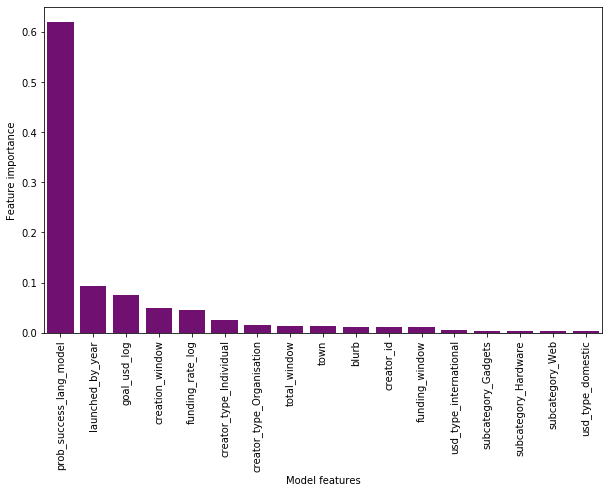

In [47]:
fi_comb = rf_feat_importance(best_rf, df_class[to_keep])
fig, ax = plt.subplots()
ax = sns.barplot(x="cols", y="imp", data=fi_comb, color = 'purple')
ax.set(xlabel='Model features', ylabel='Feature importance')
fig.set_size_inches(10,6)
plt.xticks(rotation=90)

In [48]:
predict_train_valid = best_rf.predict(comb_df[to_keep])
predict_test = best_rf.predict(test_df_comb[to_keep])
print_outputs(predict_train_valid, predict_test, comb_y, test_y)

Train results,  f1_score:  0.8300267228115636
Test results,  f1_score:  0.737283064033513
-------
Train results,  ROC_score:  0.8260851615568685
Test results,  ROC_score:  0.7412868068189475
-------
Train results,  accuracy_score:  0.8256210019107751
Test results,  accuracy_score:  0.7400828892835998


### Prediction bands

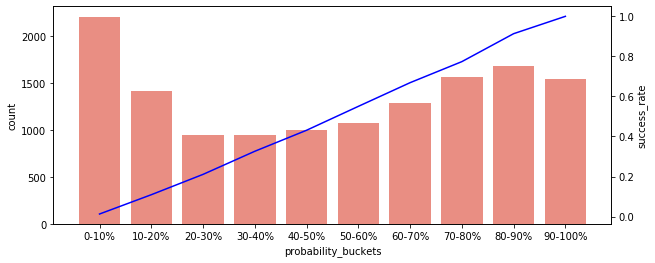

In [49]:
df_output = df
df_output['comb_model_output'] = best_rf.predict_proba(df_class[to_keep])[:,1]
size_bins = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
prob_buckets = ['0-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-100%']
df_output['comb_model_pred_bucket'] = pd.cut(df_output.comb_model_output, size_bins)
results = df_output[['successful','comb_model_pred_bucket']].groupby(['comb_model_pred_bucket']).agg(['count','mean'])
results.reset_index(inplace=True)
results.columns = ['comb_model_pred_bucket','count','success_rate']
results['probability_buckets'] = np.array(prob_buckets)

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

sns.barplot(x='probability_buckets', y='count', data= results, color='salmon', ax=ax1)
sns.lineplot(x='probability_buckets', y='success_rate', data= results, color='blue', ax=ax2)

plt.show()
sns.set()


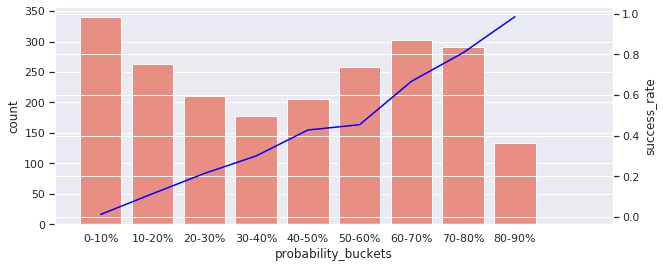

In [50]:
results_validation = df_output[df_output.launched_by_year == 2018][['successful','comb_model_pred_bucket']].groupby(['comb_model_pred_bucket']).agg(['count','mean'])
results_validation.reset_index(inplace=True)
results_validation.columns = ['comb_model_pred_bucket','count','success_rate']
results_validation['probability_buckets'] = np.array(prob_buckets)

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

sns.barplot(x='probability_buckets', y='count', data= results_validation, color='salmon', ax=ax1)
sns.lineplot(x='probability_buckets', y='success_rate', data= results_validation, color='blue', ax=ax2)

plt.show()
sns.set()

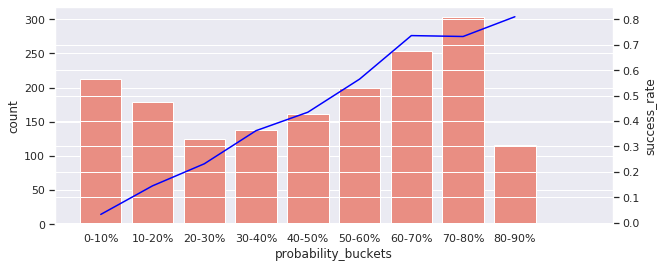

In [51]:
results_test = df_output[df_output.launched_by_year == 2019][['successful','comb_model_pred_bucket']].groupby(['comb_model_pred_bucket']).agg(['count','mean'])
results_test.reset_index(inplace=True)
results_test.columns = ['comb_model_pred_bucket','count','success_rate']
results_test['probability_buckets'] = np.array(prob_buckets)

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

sns.barplot(x='probability_buckets', y='count', data= results_test, color='salmon', ax=ax1)
sns.lineplot(x='probability_buckets', y='success_rate', data= results_test, color='blue', ax=ax2)

plt.show()
sns.set()

### Model interpretation

#### Partial dependence

In [52]:
to_keep

['prob_success_lang_model',
 'launched_by_year',
 'goal_usd_log',
 'funding_rate_log',
 'creation_window',
 'subcategory_Web',
 'subcategory_Hardware',
 'creator_type_Individual',
 'usd_type_domestic',
 'creator_type_Organisation',
 'total_window',
 'subcategory_Gadgets',
 'funding_window',
 'usd_type_international',
 'town',
 'blurb',
 'creator_id']

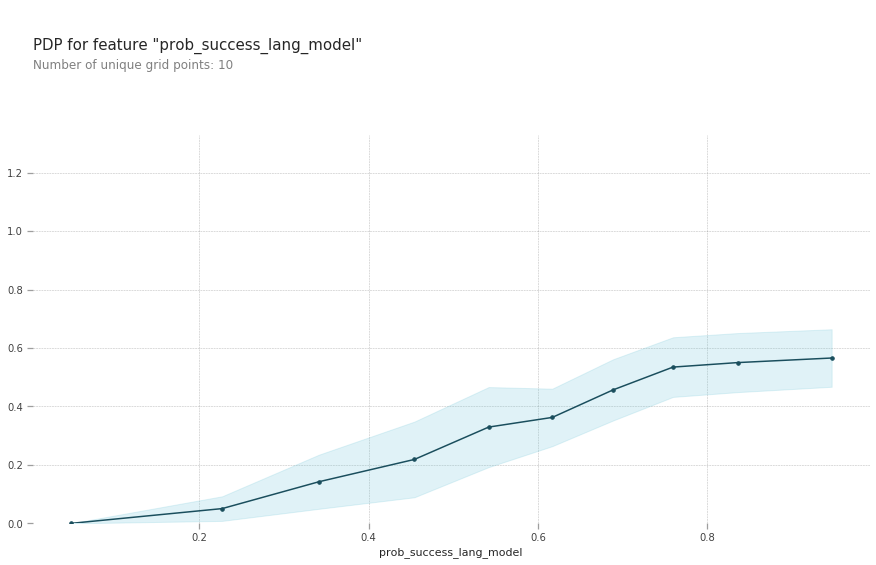

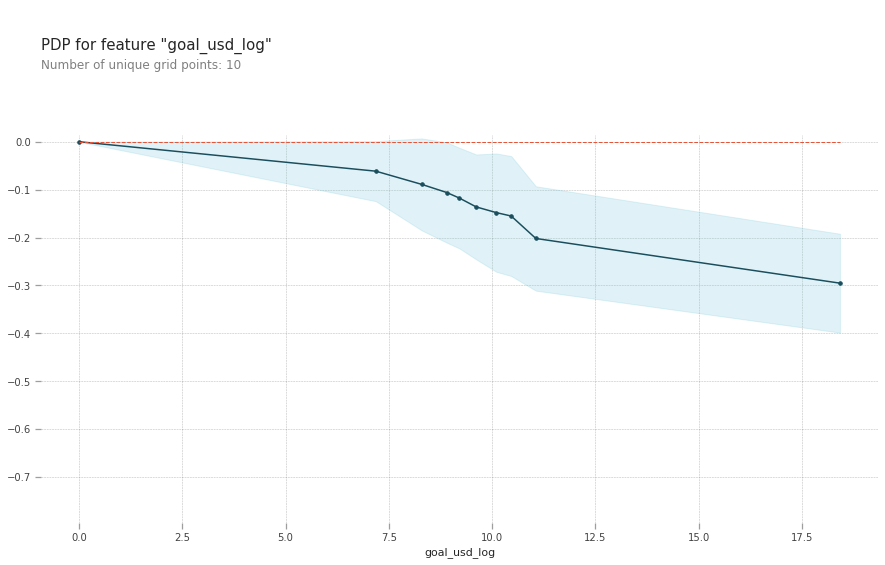

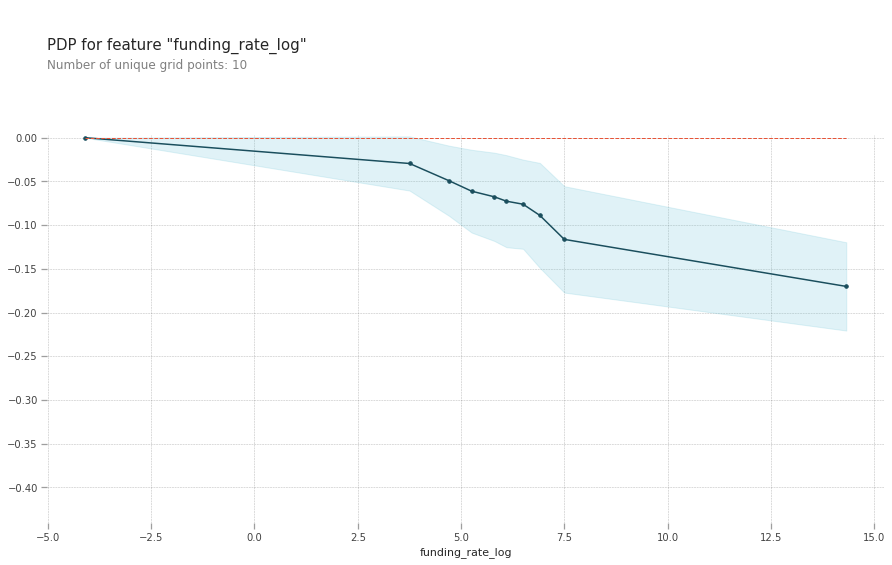

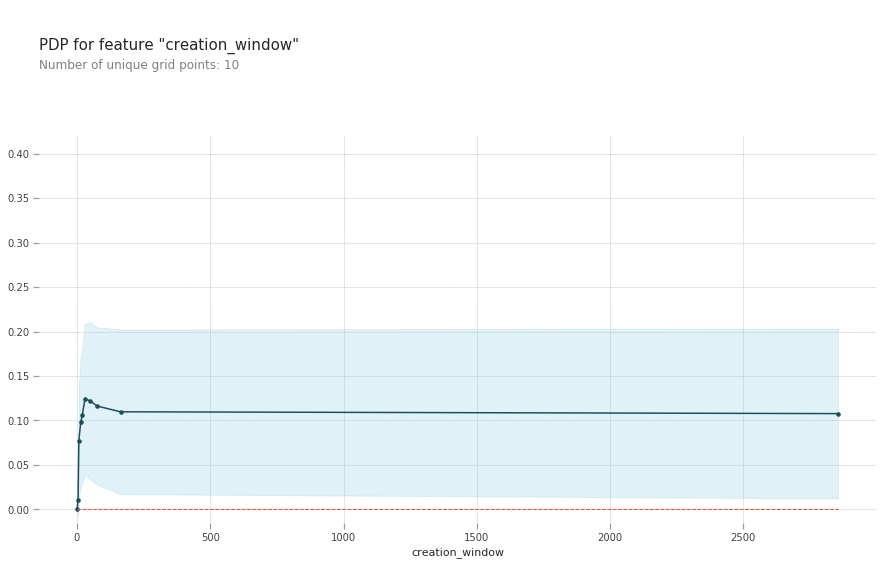

In [65]:
for test_feature in ['prob_success_lang_model','goal_usd_log', 'funding_rate_log', 'creation_window']:
  pdp_success = pdp.pdp_isolate(model=best_rf, dataset=test_df_comb[to_keep], model_features=to_keep, feature=test_feature)
  pdp.pdp_plot(pdp_success, test_feature)
  #pdp.info_plots.target_plot(pdp_success, test_feature)
  plt.show()

SHAP analysis

In [0]:
explainer = shap.TreeExplainer(best_rf)

In [97]:
# Single case explainer

shap_values = explainer.shap_values(test_df_comb[to_keep])
row_to_show = 50
data_for_prediction = test_df_comb[to_keep].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
#data_for_prediction
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

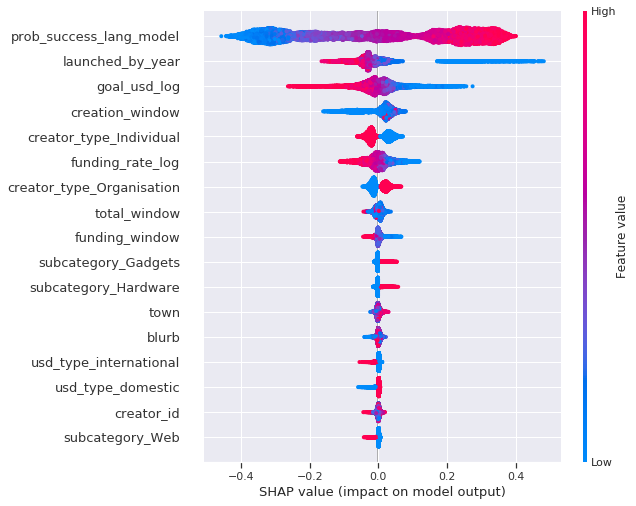

In [89]:
# All factors
#explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(df_class[to_keep])
shap.summary_plot(shap_values[1], df_class[to_keep])

#### Lime analysis

In [0]:
predict_train_valid = best_rf.predict(comb_df[to_keep])
predict_test = best_rf.predict(test_df_comb[to_keep])
print_outputs(predict_train_valid, predict_test, comb_y, test_y)

In [0]:
# https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=test_df_comb[to_keep].values,
                                                   feature_names=test_df_comb[to_keep].columns, 
                                                   class_names=test_y,
                                                   discretize_continuous=True)
                                                 # mode="classification")

In [0]:
i = np.random.randint(0, test_df_comb[to_keep].shape[0])
exp = explainer.explain_instance(test_df_comb[to_keep].iloc[i], best_rf.predict_proba, num_features=5, top_labels=1)

In [0]:
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

### Classfication Auto ML

In [0]:
automl = autosklearn.classification.AutoSklearnClassifier()
%time automl.fit(comb_df, comb_y)

In [0]:
print(automl.show_models())

In [0]:
predict_train_valid = automl.predict(comb_df)
predict_test = automl.predict(test_df_comb[to_keep])
print_outputs(predict_train_valid, predict_test, comb_y, test_y_comb)

### Regression - how much do projects raise?

In [0]:
#df_rf_reg = df.drop(['perc_target','prediction_from_lang_model'],axis=1)
#train_cats(df_rf_reg)
#df_reg, y_reg, nas_reg = proc_df(df_rf_reg.drop(['successful'],axis=1), 'perc_target', max_n_cat=10)

In [0]:
#rf_reg = RandomForestRegressor(n_estimators= 10, n_jobs=3)
#grid_param_rf = [{'min_samples_leaf': [2,5,10,20,30], 'max_features' :  ['sqrt',0.2,0.5,1]}]
#para_search_rf_reg = ms.GridSearchCV(estimator=rf_reg, param_grid=grid_param_rf, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
#para_search_rf_reg = para_search_rf_reg.fit(df_reg, y_reg)
#tuning_results_rf_reg = pd.DataFrame(para_search_rf_reg.cv_results_)
#tuning_results_rf_reg['RMSE'] = np.sqrt(abs(tuning_results_rf_reg.mean_test_score))
#tuning_results_rf_reg.sort_values('RMSE').head()

In [0]:
#rf_reg = RandomForestRegressor(n_estimators = 200)
#reg_rf = para_search_rf_reg.best_estimator_
#reg_rf.fit(df_reg, y_reg)
#print(reg_rf.score(df_reg, y_reg))
#rf_feat_importance(reg_rf, df_reg)